In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools as ft

import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

import kelp_compute

sp.init_printing()
%matplotlib inline

from fortran_wrappers.pykelp3d_wrap import pykelp3d_wrap as f90
f90.solve_rte_with_callbacks?

In [3]:
space = sp.var('x, y, z')
x, y, z = space
vec_x = sp.Matrix(space)

angle = sp.var(r'theta, phi')
th, ph = angle
vec_om = sp.Matrix([sp.sin(ph)*sp.cos(th), sp.sin(ph)*sp.sin(th), sp.cos(ph)])
delta = sp.var(r'Delta')

angle_prime = sp.var(r'theta_p, phi_p')
thp, php = angle_prime
vec_omp = sp.Matrix([sp.sin(php)*sp.cos(thp), sp.sin(php)*sp.sin(thp), sp.cos(php)])

In [4]:
def grad(expr, space=space):
    return sp.Matrix([sp.diff(expr, d) for d in space])

In [5]:
def sphere_integral(expr, angle):
    theta, phi = angle
    return sp.integrate(expr*sp.sin(phi), (theta, 0, 2*sp.pi), (phi, 0, sp.pi))

In [6]:
def dot(a, b):
    return sum(a.T * b)

In [7]:
def gen_grid(ns, nz, na, rope_spacing, zmax):
    ds = rope_spacing/ns
    dz = zmax/nz
    
    x = y = -rope_spacing/2 + ds * (np.arange(ns) + 1/2)
    z = dz * (np.arange(nz) + 1/2)
    
    ntheta = nphi = na
    nomega = ntheta*(nphi-2) + 2
    
    dtheta = 2*np.pi/ntheta
    dphi = np.pi/(nphi-1)
    
    theta = dtheta * np.arange(ntheta)
    phi = dphi * np.arange(nphi)

    l = np.arange(ntheta)
    m = np.arange(nphi)
    p = np.arange(nomega)

    L, M = np.meshgrid(l, m, indexing='ij')
    
    phat = (M-1)*ntheta + L + 1
    phat[:,0] = 0
    phat[:,-1] = nomega-1
    
    theta_p = np.zeros(nomega)
    phi_p = np.zeros(nomega)
    theta_p[phat] = theta[L]
    theta_p[0] = theta_p[-1] = 0
    phi_p[phat] = phi[M]
    
    # A bit redundant, but seems to work
    X, Y, Z, Theta = np.meshgrid(x, y, z, theta_p, indexing='ij')
    _, _, _, Phi = np.meshgrid(x, y, z, phi_p, indexing='ij')
    
    return X, Y, Z, Theta, Phi

---

In [115]:
def calculate_source(L, b, a, beta, params=()):
    L_om = L(*space, *angle, *params)
    L_omp = L(*space, *angle_prime, *params)
    
    deriv = dot(vec_om, grad(L_om))
    atten = (a(*space)+b)*L_om
    
    scat_integrand = beta(dot(vec_om, grad(L_omp))) * L_omp
    scat = b * sphere_integral(scat_integrand, angle=angle_prime)
    
    source = deriv + atten - scat
    
    return source

In [116]:
def calculate_bc(L, params=()):
    z = space[-1]
    zmin = 0
    return L(*space, *angle, *params).subs(z, zmin)

In [117]:
b = sp.var('b')
params = sp.var('alpha, gamma')

In [118]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [119]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        *(2+sp.sin(phi))
    )

In [120]:
def uniform_L(x, y, z, theta, phi, alpha, gamma):
    return alpha

In [121]:
def tanh_L(x, y, z, theta, phi, alpha, gamma):
    return alpha * sp.tanh(gamma-z)

In [122]:
# TODO: Should be periodic on correct grid
def prod_a(x, y, z):
    return (2+sp.sin(2*sp.pi*x))*(2+sp.sin(2*sp.pi*y))*(1+sp.tanh(z-gamma))

In [123]:
def uniform_a(x, y, z):
    return 1

In [124]:
prod_source = calculate_source(prod_L, b, prod_a, uniform_vsf, params)
prod_bc = calculate_bc(prod_L, params)

In [125]:
uniform_source = calculate_source(uniform_L, b, uniform_a, uniform_vsf, params)
uniform_bc = calculate_bc(uniform_L, params)

In [126]:
tanh_source = calculate_source(tanh_L, b, uniform_a, uniform_vsf, params)
tanh_bc = calculate_bc(tanh_L, params)

In [127]:
tanh_source

In [128]:
alpha = 1
gamma = 1
b = 0.0

In [129]:
prod_source_sym = sp.lambdify(
    (*space, *angle), 
    prod_source.subs('alpha', alpha).subs('gamma', gamma).subs('b', b),
    modules=("sympy",)
)

prod_a_sym = sp.lambdify(
    space,
    prod_a(*space),
    modules=("sympy",)
)

prod_bc_sym = sp.lambdify(
    angle, 
    prod_bc.subs('alpha', alpha).subs('gamma', gamma),
    modules=("sympy",)
)

prod_sol_sym = sp.lambdify(
    (*space, *angle), 
    prod_L(*space, *angle, *params).subs('alpha', alpha).subs('gamma', gamma).subs('b', b),
    modules=("sympy",)
)

uniform_vsf_sym = sp.lambdify(
    (delta,), 
    uniform_vsf(delta),
    modules=("sympy",)
)

uniform_a_sym = sp.lambdify(
    space,
    uniform_a(*space),
    modules=("sympy",)
)

uniform_source_sym = sp.lambdify(
    (*space, *angle), 
    uniform_source.subs('alpha', alpha).subs('gamma', gamma).subs('b', b),
    modules=("sympy",)
)

uniform_bc_sym = sp.lambdify(
    angle, 
    uniform_bc.subs('alpha', alpha).subs('gamma', gamma),
    modules=("sympy",)
)

uniform_sol_sym = sp.lambdify(
    (*space, *angle), 
    uniform_L(*space, *angle, *params).subs('alpha', alpha).subs('gamma', gamma).subs('b', b),
    modules=("sympy",)
)


tanh_source_sym = sp.lambdify(
    (*space, *angle), 
    tanh_source.subs('alpha', alpha).subs('gamma', gamma).subs('b', b),
    modules=("sympy",)
)

tanh_bc_sym = sp.lambdify(
    angle, 
    tanh_bc.subs('alpha', alpha).subs('gamma', gamma),
    modules=("sympy",)
)

tanh_sol_sym = sp.lambdify(
    (*space, *angle), 
    tanh_L(*space, *angle, *params).subs('alpha', alpha).subs('gamma', gamma).subs('b', b),
    modules=("sympy",)
)

In [130]:
abs_func = uniform_a_sym
source_func = tanh_source_sym
bc_func = tanh_bc_sym
vsf_func = uniform_vsf_sym
sol_func = tanh_sol_sym

In [131]:
abs_func_N = kelp_compute.sym_to_num(abs_func, *space)
source_func_N = kelp_compute.sym_to_num(source_func, *space, *angle)
bc_func_N = kelp_compute.sym_to_num(bc_func, *angle)
vsf_func_N = kelp_compute.sym_to_num(vsf_func, delta)
sol_func_N = kelp_compute.sym_to_num(sol_func, *space, *angle)

In [132]:
source_func(*space, *angle)

## Numerical Solution

In [133]:
ns = 4
nz = 20
na = 4
nomega = na*(na-2) + 2
rope_spacing = 1
zmax = 1

lis_opts = "-i gmres"
fd_flag = False
num_scatters = 0

scalar_params, results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_func, source_func, bc_func, vsf_func,
    num_scatters, fd_flag, lis_opts
)

In [134]:
x, y, z, theta, phi = gen_grid(ns, nz, na, rope_spacing, zmax)

true_sol = sol_func_N(x, y, z, theta, phi)
asymptotic_sol = results['rad']

## Plot

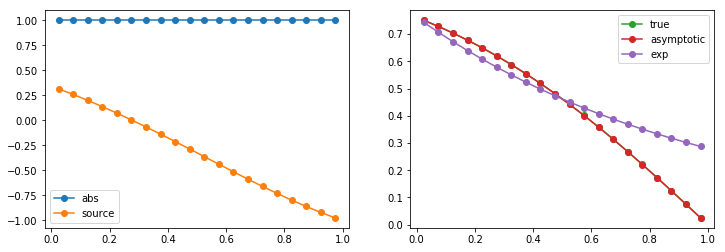

In [135]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(z[0,0,:,0], abs_func_N(x,y,z)[0,0,:,0], 'C0o-', label='abs')
plt.plot(z[0,0,:,0], source_func_N(x,y,z,theta,phi)[0,0,:,0], 'C1o-', label='source')
plt.legend()

plt.subplot(1,2,2)
plt.plot(z[0,0,:,0], true_sol[0,0,:,0], 'C2o-', label='true')
plt.plot(z[0,0,:,0], asymptotic_sol[0,0,:,0], 'C3o-', label='asymptotic')
plt.plot(z[0,0,:,0], (np.tanh(1)*np.exp(-z))[0,0,:,0], 'C4o-', label='exp')
plt.legend()

## Debug source term

Source term seems too high, so try substituting parameters,
then plugging in analytical solution.

In [136]:
def check_sol(L, b, a, beta, sigma):
    L_om = L(*space, *angle)
    L_omp = L(*space, *angle_prime)
    
    deriv = dot(vec_om, grad(L_om))
    atten = (a(*space)+b)*L_om
    
    scat_integrand = beta(dot(vec_om, grad(L_omp))) * L_omp
    scat = sphere_integral(scat_integrand, angle=angle_prime)
    
    source = sigma(*space, *angle)
    
    return source - deriv + atten - scat

In [137]:
check_sol(sol_func, b, abs_func, vsf_func, source_func)

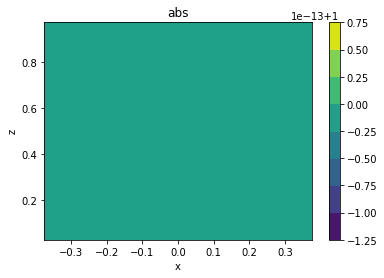

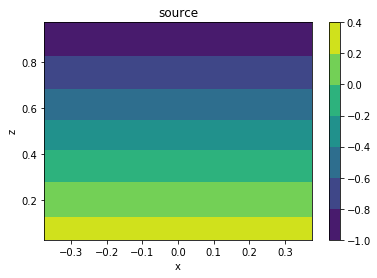

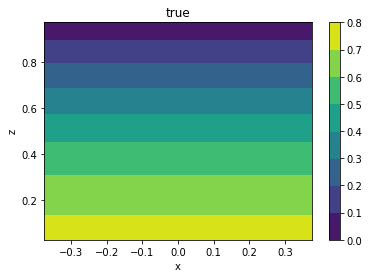

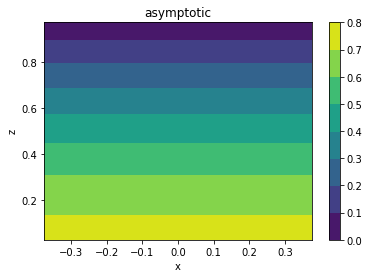

In [138]:
plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], abs_func_N(x,y,z)[:,0,:,0])
plt.colorbar()
plt.title('abs')
plt.xlabel('x')
plt.ylabel('z')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], source_func_N(x,y,z,theta,phi)[:,0,:,0,])
plt.colorbar()
plt.title('source')
plt.xlabel('x')
plt.ylabel('z')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], true_sol[:,0,:,0])
plt.colorbar()
plt.title('true')
plt.xlabel('x')
plt.ylabel('z')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], asymptotic_sol[:,0,:,0])
plt.colorbar()
plt.title('asymptotic')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

In [69]:
def print_stats(x):
    print("min:", np.min(x))
    print("max:", np.max(x))
    print("mean:", np.mean(x))

In [70]:
print("abs:")
print_stats(abs_func_N(x, y, z))
print()

print("source:")
print_stats(source_func_N(x, y, z, theta, phi))
print()

print("bc:")
print_stats(bc_func_N(theta, phi))
print()

abs:
min: 1
max: 1
mean: 1.0

source:
min: -0.9987255736300098
max: 0.9987255736300098
mean: -9.238213197532601e-17

bc:
min: 0.7615941559557649
max: 0.7615941559557649
mean: 0.7615941559557646

